# DeepSphere using SHREC17 dataset
### Benchmark with Cohen method S2CNN[[1]](http://arxiv.org/abs/1801.10130) and Esteves method[[2]](http://arxiv.org/abs/1711.06721)
Multi-class classification of 3D objects, using the interesting property of rotation equivariance.

The 3D objects are projected on a unit sphere.
Cohen and Esteves use equiangular sampling, while our method use a HEAlpix sampling

Several features are collected:
* projection ray length (from sphere border to intersection [0, 2])
* cos/sin with surface normal
* same features using the convex hull of the 3D object

## 0.1 Load libs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp

In [3]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

from SHREC17.load_shrec import fix_dataset, Shrec17Dataset, Shrec17DatasetCache, Shrec17DatasetTF

## 0.2 Define parameters

In [4]:
Nside = 64
experiment_type = 'CNN' # 'FCN'
ename = '_'+experiment_type
datapath = '../data/shrec17/' # localisation of the .obj files

In [5]:
noise_dataset = True    # use perturbed dataset (Cohen and Esteves do the same)
augmentation = 1        # number of element per file (1 = no augmentation of dataset)

## 1 Load dataset

In [6]:
# if datasets are already downloaded but not preprocessed
fix = False
download = False
if fix:
    fix_dataset(datapath+'val_perturbed')
    fix_dataset(datapath+'test_perturbed')

download dataset if True, preprocess data and store it in npy files, and load it in a dataset object

In [7]:
#train_dataset = Shrec17DatasetCache(datapath, 'train', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)


Better to keep validation and testing set in RAM, but not always possible

In [8]:
val_dataset = Shrec17DatasetCache(datapath, 'val', perturbed=noise_dataset, download=download, nside=Nside, augmentation=1, nfile=None)

Try do make a tensorflow dataset object

In [9]:
train_TFDataset = Shrec17DatasetTF(datapath, 'train', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)

In [10]:
#dataset = train_TFDataset.get_tf_dataset(32)

In [11]:
# import time
# import tensorflow as tf

# #dataset = tf_dataset_file(datapath, dataset, file_pattern, 32, Nside, augmentation)
# t_start = time.time()
# data_next = dataset.make_one_shot_iterator().get_next()
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# steps = train_TFDataset.N // 32 + 1
# with tf.Session(config=config) as sess:
#     sess.run(tf.global_variables_initializer())
#     try:
#         for i in range(steps):
#             out = sess.run(data_next)
#     except tf.errors.OutOfRangeError:
#         print("Done") # Never reach this as will iterate on infinite sets
# t_end = time.time()
# print(str(t_end-t_start)+" s")

# # t_start = time.time()
# # data_iter = train_dataset.iter(32)
# # steps = int(train_dataset.N / 32)
# # for i in range(steps):
# #     next(data_iter)
# #     #feed_dict = {self.ph_data: batch_data, self.ph_labels: batch_labels, self.ph_training: True}
# # t_end = time.time()
# # print(str(t_end-t_start)+" s")

## 1.1 Preprocess the dataset

Shuffle the training dataset and print the classes distribution

In [12]:
nclass = train_TFDataset.nclass
num_elem = train_TFDataset.N
#ids_train = train_dataset.ids
print('number of class:',nclass,'\nnumber of elements:',num_elem)#,'\nfirst id:',ids_train[0])

number of class: 55 
number of elements: 31364


In [13]:
# x_val, labels_val, ids_val = val_dataset.return_data(train=False)

In [14]:
nfeat = 6#x_val.shape[-1]

## 2 Classification using DeepSphere

Use of the Dataset object used for other DeepSphere experiments

In [12]:
# #training = LabeledDatasetWithNoise(x_train, labels_train, end_level=sigma_noise)
# #training = LabeledDataset(x_train, labels_train)
# validation = LabeledDataset(x_val, labels_val)

In [15]:
#EXP_NAME = 'shrec17_best_4K_cache_{}aug_{}sides{}'.format(augmentation, Nside, ename)
#EXP_NAME = 'shrec17_Cohen_simple_SGD_max_nsides_300epoch_{}sides{}'.format(Nside, ename)
EXP_NAME = "shrec17_best_5K_cache_1aug_64sides_CNN"
#EXP_NAME = 'essai_TFDataset'

Load model with hyperparameters chosen.
For each experiment, a new EXP_NAME is chosen, and new hyperparameters are store.
All informations are present 'DeepSphere/Shrec17/experiments.md'
The fastest way to reproduce an experiment is to revert to the commit of the experiment to load the correct files and notebook

Adding a layer in the fully connected can be beneficial

In [21]:
params = hyperparameters.get_params_shrec17_optim(num_elem, EXP_NAME, Nside, nclass, nfeat_in=nfeat, architecture=experiment_type)
params["tf_dataset"] = train_TFDataset.get_tf_dataset(params["batch_size"])
params["std"] = 0.001
model = models.deepsphere(**params)

#sides: [64, 32, 16, 8, 4, 2, 2]
#pixels: [49152, 12288, 3072, 768, 192, 48, 48]
#samples per batch: 32
=> #pixels per batch (input): 1,572,864
=> #pixels for training (input): 77,080,166,400
Learning rate will start at 1.0e-02 and finish at 1.0e-02.
NN architecture
  input: M_0 = 49152
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 49152 * 16 / 4 = 196608
    weights: F_0 * F_1 * K_1 = 6 * 16 * 5 = 480
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 12288 * 32 / 4 = 98304
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 3072 * 64 / 4 = 49152
    weights: F_2 * F_3 * K_3 = 32 * 64 * 5 = 10240
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 768 * 128 / 4 = 24576
    weights: F_3 * F_4 * K_4 = 64 * 128 * 5 = 40960
    biases: F_4 = 128
    batch normalization
  layer 5: 

In [14]:
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

Find a correct learning rate

In [ ]:
backup = params.copy()

params, learning_rate = utils.test_learning_rates(params, train_TFDataset.N, 1e-6, 1e-1, num_epochs=20)

shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)

model = models.deepsphere(**params)
_, loss_validation, _, _ = model.fit(train_TFDataset, val_dataset, use_tf_dataset=True, cache=True)

params.update(backup)

plt.semilogx(learning_rate, loss_validation, '.-')

NN architecture
  input: M_0 = 196608
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 196608 * 16 / 4 = 786432
    weights: F_0 * F_1 * K_1 = 6 * 16 * 5 = 480
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 49152 * 32 / 4 = 393216
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 12288 * 64 / 4 = 196608
    weights: F_2 * F_3 * K_3 = 32 * 64 * 5 = 10240
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 3072 * 128 / 4 = 98304
    weights: F_3 * F_4 * K_4 = 64 * 128 * 5 = 40960
    biases: F_4 = 128
    batch normalization
  layer 5: cgconv5
    representation: M_4 * F_5 / p_5 = 768 * 256 / 4 = 49152
    weights: F_4 * F_5 * K_5 = 128 * 256 * 5 = 163840
    biases: F_5 = 256
    batch normalization
  Statistical layer: mean
    representation: 1 * 256 = 256
  layer 6: logits

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 0.76 (39 / 5133), f1 (weighted): 0.80, loss: 4.29e+00
  CPU time: 1477s, wall time: 797s, perf_time_load: 1.16s, perf_time: 1.16s
step 980 / 19602 (epoch 1.00 / 20):
  learning_rate = 3.16e-06, training loss = 4.13e+00
  validation accuracy: 3.78 (194 / 5133), f1 (weighted): 2.88, loss: 4.19e+00
  CPU time: 2964s, wall time: 1587s, perf_time_load: 1.13s, perf_time: 1.13s
step 1470 / 19602 (epoch 1.50 / 20):
  learning_rate = 5.62e-06, training loss = 4.08e+00
  validation accuracy: 10.29 (528 / 5133), f1 (weighted): 4.54, loss: 4.00e+00
  CPU time: 4446s, wall time: 2374s, perf_time_load: 1.16s, perf_time: 1.16s
step 1960 / 19602 (epoch 2.00 / 20):
  learning_rate = 9.99e-06, training loss = 3.78e+00
  validation accuracy: 26.57 (1364 / 5133), f1 (weighted): 15.49, loss: 3.70e+00
  CPU time: 5924s, wall time: 3166s, perf_time_load: 1.15s, perf_time: 1.15s
step 2450 / 19602 (epoch 2.50 / 20):
  learning_rate = 1.78e-05, training loss = 3.08e+00
  validation accura

In [ ]:
shutil.rmtree('summaries/lr_finder/', ignore_errors=True)
shutil.rmtree('checkpoints/lr_finder/', ignore_errors=True)

0.9 seems to be a good learning rate for SGD with current parameters

## 2.2 Train Network

In [17]:
print("the number of parameters in the model is: {:,}".format(model.get_nbr_var()))

conv1/weights:0
conv1/bias:0
conv2/weights:0
conv2/bias:0
conv3/weights:0
conv3/bias:0
conv4/weights:0
conv4/bias:0
conv5/weights:0
conv5/bias:0
logits/weights:0
the number of parameters in the model is: 189,040


In [16]:
accuracy_validation, loss_validation, loss_training, t_step = model.fit(train_TFDataset, val_dataset, use_tf_dataset=True, cache=True)

step 735 / 147018 (epoch 0.25 / 50):
  learning_rate = 1.00e-02, training loss = 9.60e-01


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 68.17 (3499 / 5133), f1 (weighted): 65.15, loss: 1.38e+00
  CPU time: 385s, wall time: 196s, perf_time_load: 0.19s, perf_time: 0.19s
step 1470 / 147018 (epoch 0.50 / 50):
  learning_rate = 1.00e-02, training loss = 1.11e+00
  validation accuracy: 71.62 (3676 / 5133), f1 (weighted): 68.85, loss: 1.24e+00
  CPU time: 754s, wall time: 382s, perf_time_load: 0.19s, perf_time: 0.19s
step 2205 / 147018 (epoch 0.75 / 50):
  learning_rate = 1.00e-02, training loss = 7.25e-01
  validation accuracy: 74.65 (3832 / 5133), f1 (weighted): 72.81, loss: 1.13e+00
  CPU time: 1144s, wall time: 565s, perf_time_load: 0.19s, perf_time: 0.19s
step 2940 / 147018 (epoch 1.00 / 50):
  learning_rate = 1.00e-02, training loss = 5.75e-01
  validation accuracy: 76.17 (3910 / 5133), f1 (weighted): 74.58, loss: 1.06e+00
  CPU time: 1539s, wall time: 748s, perf_time_load: 0.20s, perf_time: 0.20s
step 3675 / 147018 (epoch 1.25 / 50):
  learning_rate = 1.00e-02, training loss = 9.17e-01
  validati

  validation accuracy: 81.86 (4202 / 5133), f1 (weighted): 81.36, loss: 8.29e-01
  CPU time: 13237s, wall time: 6254s, perf_time_load: 0.19s, perf_time: 0.19s
step 25725 / 147018 (epoch 8.75 / 50):
  learning_rate = 1.00e-02, training loss = 3.92e-01
  validation accuracy: 81.10 (4163 / 5133), f1 (weighted): 80.02, loss: 8.93e-01
  CPU time: 13621s, wall time: 6437s, perf_time_load: 0.19s, perf_time: 0.19s
step 26460 / 147018 (epoch 9.00 / 50):
  learning_rate = 1.00e-02, training loss = 3.84e-01
  validation accuracy: 81.67 (4192 / 5133), f1 (weighted): 80.74, loss: 8.50e-01
  CPU time: 14007s, wall time: 6621s, perf_time_load: 0.19s, perf_time: 0.19s
step 27195 / 147018 (epoch 9.25 / 50):
  learning_rate = 1.00e-02, training loss = 5.14e-01
  validation accuracy: 82.23 (4221 / 5133), f1 (weighted): 81.40, loss: 8.49e-01
  CPU time: 14391s, wall time: 6805s, perf_time_load: 0.19s, perf_time: 0.19s
step 27930 / 147018 (epoch 9.50 / 50):
  learning_rate = 1.00e-02, training loss = 8.75e

step 49245 / 147018 (epoch 16.75 / 50):
  learning_rate = 1.00e-02, training loss = 3.65e-01
  validation accuracy: 81.69 (4193 / 5133), f1 (weighted): 80.75, loss: 8.93e-01
  CPU time: 25791s, wall time: 12307s, perf_time_load: 0.19s, perf_time: 0.19s
step 49980 / 147018 (epoch 17.00 / 50):
  learning_rate = 1.00e-02, training loss = 8.79e-01
  validation accuracy: 82.14 (4216 / 5133), f1 (weighted): 81.46, loss: 8.96e-01
  CPU time: 26152s, wall time: 12488s, perf_time_load: 0.19s, perf_time: 0.19s
step 50715 / 147018 (epoch 17.25 / 50):
  learning_rate = 1.00e-02, training loss = 6.17e-01
  validation accuracy: 81.82 (4200 / 5133), f1 (weighted): 81.49, loss: 8.89e-01
  CPU time: 26526s, wall time: 12668s, perf_time_load: 0.19s, perf_time: 0.19s
step 51450 / 147018 (epoch 17.50 / 50):
  learning_rate = 1.00e-02, training loss = 6.39e-01
  validation accuracy: 82.10 (4214 / 5133), f1 (weighted): 81.14, loss: 9.04e-01
  CPU time: 26902s, wall time: 12850s, perf_time_load: 0.19s, perf_

step 73500 / 147018 (epoch 25.00 / 50):
  learning_rate = 1.00e-02, training loss = 3.11e-01
  validation accuracy: 81.96 (4207 / 5133), f1 (weighted): 81.49, loss: 9.13e-01
  CPU time: 38290s, wall time: 18317s, perf_time_load: 0.19s, perf_time: 0.19s
step 74235 / 147018 (epoch 25.25 / 50):
  learning_rate = 1.00e-02, training loss = 3.72e-01
  validation accuracy: 82.47 (4233 / 5133), f1 (weighted): 81.72, loss: 9.00e-01
  CPU time: 38672s, wall time: 18499s, perf_time_load: 0.19s, perf_time: 0.19s
step 74970 / 147018 (epoch 25.50 / 50):
  learning_rate = 1.00e-02, training loss = 6.49e-01
  validation accuracy: 83.11 (4266 / 5133), f1 (weighted): 82.40, loss: 8.75e-01
  CPU time: 39018s, wall time: 18681s, perf_time_load: 0.19s, perf_time: 0.19s
step 75705 / 147018 (epoch 25.75 / 50):
  learning_rate = 1.00e-02, training loss = 4.78e-01
  validation accuracy: 83.11 (4266 / 5133), f1 (weighted): 82.62, loss: 8.73e-01
  CPU time: 39384s, wall time: 18863s, perf_time_load: 0.19s, perf_

step 97755 / 147018 (epoch 33.25 / 50):
  learning_rate = 1.00e-02, training loss = 3.27e-01
  validation accuracy: 82.00 (4209 / 5133), f1 (weighted): 81.20, loss: 9.46e-01
  CPU time: 50318s, wall time: 24531s, perf_time_load: 0.19s, perf_time: 0.19s
step 98490 / 147018 (epoch 33.50 / 50):
  learning_rate = 1.00e-02, training loss = 4.61e-01
  validation accuracy: 81.14 (4165 / 5133), f1 (weighted): 80.21, loss: 9.68e-01
  CPU time: 50632s, wall time: 24712s, perf_time_load: 0.19s, perf_time: 0.19s
step 99225 / 147018 (epoch 33.75 / 50):
  learning_rate = 1.00e-02, training loss = 4.23e-01
  validation accuracy: 81.82 (4200 / 5133), f1 (weighted): 81.31, loss: 9.33e-01
  CPU time: 50979s, wall time: 24895s, perf_time_load: 0.19s, perf_time: 0.19s
step 99960 / 147018 (epoch 34.00 / 50):
  learning_rate = 1.00e-02, training loss = 2.93e-01


KeyboardInterrupt: 

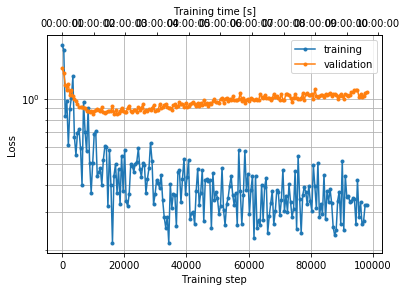

In [22]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

Remarks

In [16]:
model.evaluate(x_train, labels_train)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_nsides_300epoch_reg_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_nsides_300epoch_reg_32sides_CNN/model-294037


('accuracy: 96.53 (30277 / 31364), f1 (weighted): 96.54, loss: 1.16e-01\nCPU time: 275s, wall time: 257s',
 96.53424308123964,
 96.54157073077505,
 0.115866209483545)

In [ ]:
#predictions, loss = model.predict(x_val, labels_val)

In [14]:
# model.evaluate(x_val, labels_val)
model.evaluate(val_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_cache_1aug_64sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_cache_1aug_64sides_CNN/model-98012


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


('accuracy: 80.69 (4142 / 5133), f1 (weighted): 80.12, loss: 1.07e+00\nCPU time: 55s, wall time: 52s',
 80.69355152932009,
 80.11855984053359,
 1.071748793717367)

In [15]:
# probabilities = model.probs(x_val, nclass)
probabilities, _ = model.probs(val_dataset, nclass, cache=True)
if augmentation>1:
    probabilities = probabilities.reshape((-1,augmentation,nclass))
    probabilities = probabilities.mean(axis=1)
    #ids_val = ids_val[::repeat]
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_cache_1aug_64sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_cache_1aug_64sides_CNN/model-98012


In [16]:
ids_val = val_dataset.get_ids()

In [ ]:
#predictions = predictions.astype(np.int)

In [20]:
from SHREC17.load_shrec import shrec_output

In [24]:
shrec_output(probabilities, ids_val, datapath, 'results/val_perturbed')

In [25]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_aug/val_perturbed'), exist_ok=True)
for i,_id in enumerate(ids_val):
    idfile = os.path.join(datapath,'results_aug/val_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_val[j]) for j in range(len(ids_val)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

NaN appears if remove i==j case

## test network

In [18]:
test_dataset = Shrec17Dataset(datapath, 'test', perturbed=noise_dataset, download=download, nside=Nside, augmentation=1, nfile=None)

10265it [00:59, 172.19it/s]


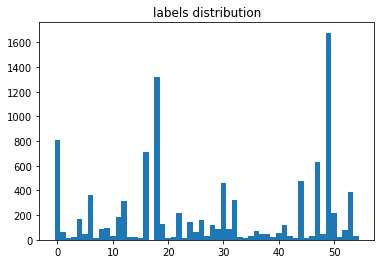

In [19]:
x_test, labels_test, ids_test = test_dataset.return_data(train=False)

In [28]:
model.evaluate(x_test, labels_test)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_cache_1aug_64sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_cache_1aug_64sides_CNN/model-98012


('accuracy: 75.99 (7800 / 10265), f1 (weighted): 76.07, loss: 1.24e+00\nCPU time: 102s, wall time: 96s',
 75.98636142230882,
 76.07329845432768,
 1.2386591787287158)

In [ ]:
#predictions = model.predict(x_test)

In [22]:
probabilities = model.probs(x_test, nclass)
if augmentation>1:
    probabilities = probabilities.reshape((-1,augmentation,nclass))
    probabilities = probabilities.mean(axis=1)
#probabilities = np.log(probabilities)
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_cache_1aug_64sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_cache_1aug_64sides_CNN/model-98012


In [ ]:
#predictions = predictions.astype(np.int)

write to file

In [30]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_aug/test_perturbed'), exist_ok=True)
for i, _id in enumerate(ids_test):
    idfile = os.path.join(datapath,'results_aug/test_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_test[j]) for j in range(len(ids_test)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

In [31]:
shrec_output(probabilities, ids_test, datapath, 'results/test_perturbed')

Why not working?

In [23]:
def _print_histogram(nclass, labels_train, labels_val=None):
    if labels_train is None:
        return
    import matplotlib.pyplot as plt
    from collections import Counter
    hist_train=Counter(labels_train)
#         for i in range(self.nclass):
#             hist_train.append(np.sum(labels_train == i))
    labels, values = zip(*hist_train.items())
    indexes = np.asarray(labels)
#     miss = set(indexes) - set(labels)
#     if len(miss) is not 0:
#         hist_train.update({elem:0 for elem in miss})
#     labels, values = zip(*hist_train.items())
    width = 1
    plt.bar(labels, values, width)
    plt.title("labels distribution")
    #plt.xticks(indexes + width * 0.5, labels)
    if labels_val is not None:
        hist_val=Counter(labels_val)
        plt.figure()
        labels, values = zip(*hist_val.items())
        indexes = np.asarray(labels)
        width = 1
        plt.bar(indexes, values, width)
        plt.title("validation labels distribution")
    plt.show()

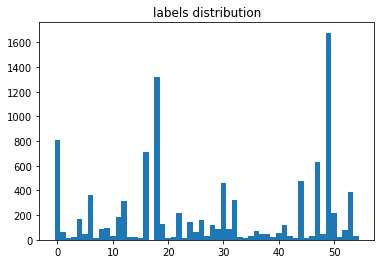

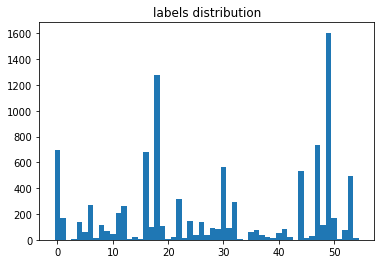

In [24]:
_print_histogram(55, labels_test)
_print_histogram(55, predictions)

In [25]:
from sklearn.metrics import confusion_matrix

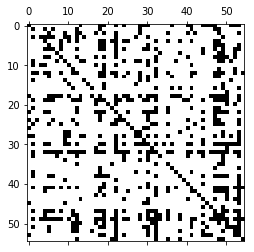

In [26]:
plt.spy(confusion_matrix(labels_test, predictions, range(55)))